1) tutorial video website link: https://wetlands.io/
2) sign up for an account on https://datapane.com; although datapane no longer actively managed, see:
   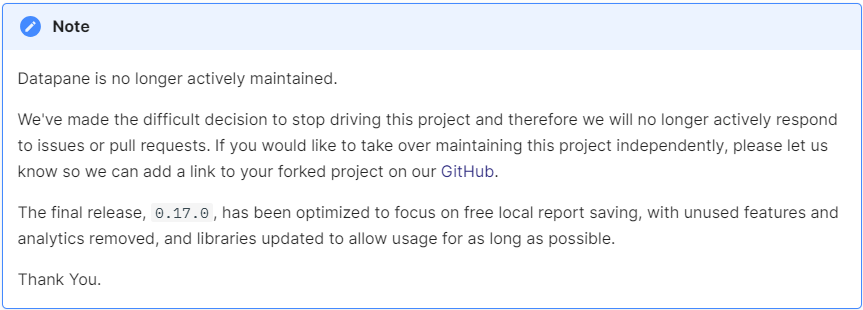
4) install and authenticate the datapane Python package (as instructed by the notebook); error:
   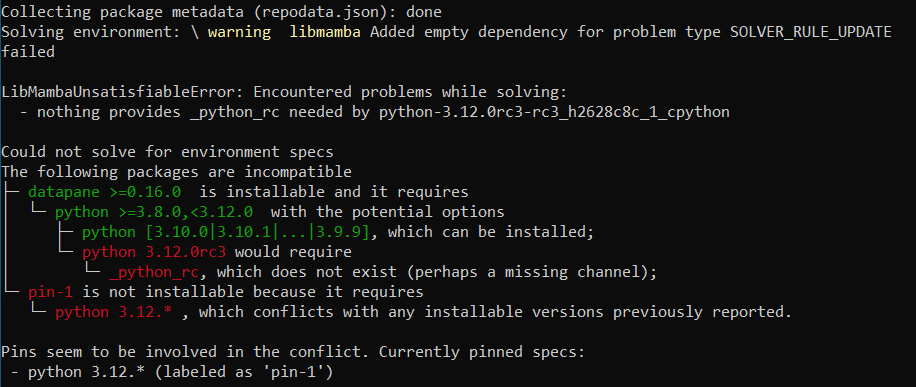

In [1]:
import ee
import geemap.foliumap as geemap

In [ ]:
# Create a map centered at (lat, lon).
Map = geemap.Map(center=[40, -100], zoom=4)

# Use an elevation dataset and terrain functions to create
# a custom visualization of topography.

# Load a global elevation image.
elev = ee.Image("USGS/GMTED2010")

# Zoom to an area of interest.
Map.setCenter(-121.069, 50.709, 6)

# Add the elevation to the map.
Map.addLayer(elev, {}, "elev")

# Use the terrain algorithms to compute a hillshade with 8-bit values.
shade = ee.Terrain.hillshade(elev)
Map.addLayer(shade, {}, "hillshade", False)

# Create a "sea" variable to be used for cartographic purposes
sea = elev.lte(0)
Map.addLayer(sea.mask(sea), {"palette": "000022"}, "sea", False)

# Create a custom elevation palette from hex strings.
elevationPalette = ["006600", "002200", "fff700", "ab7634", "c4d0ff", "ffffff"]
# Use these visualization parameters, customized by location.
visParams = {"min": 1, "max": 3000, "palette": elevationPalette}

# Create a mosaic of the sea and the elevation data
visualized = ee.ImageCollection(
    [
        # Mask the elevation to get only land
        elev.mask(sea.Not()).visualize(**visParams),
        # Use the sea mask directly to display sea.
        sea.mask(sea).visualize(**{"palette": "000022"}),
    ]
).mosaic()

# Note that the visualization image doesn't require visualization parameters.
Map.addLayer(visualized, {}, "elev palette", False)

# Convert the visualized elevation to HSV, first converting to [0, 1] data.
hsv = visualized.divide(255).rgbToHsv()
# Select only the hue and saturation bands.
hs = hsv.select(0, 1)
# Convert the hillshade to [0, 1] data, as expected by the HSV algorithm.
v = shade.divide(255)
# Create a visualization image by converting back to RGB from HSV.
# Note the cast to byte in order to export the image correctly.
rgb = hs.addBands(v).hsvToRgb().multiply(255).byte()
Map.addLayer(rgb, {}, "styled")

states = ee.FeatureCollection("TIGER/2018/States")
Map.addLayer(ee.Image().paint(states, 0, 2), {}, "US States")

In [ ]:
# Display the map.
Map

In [ ]:
Map.publish(
    name="Terrain Visualization",
    description="A folium map with Earth Engine data layers",
)